# Lunar Lander trained with Deep Q Network

## Step 0: Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import random
import cv2

## Step 1: Activate the environment and examine state/action spaces

In [2]:
env = gym.make('LunarLanderContinuous-v2')

In [3]:
print(env.observation_space.shape)
print(env.action_space)
print(env.action_space.high)
print(env.action_space.low)

(8,)
Box(2,)
[1. 1.]
[-1. -1.]


In [4]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

Let's take some random actions in the environment and see what happens...

In [ ]:
scores = []
for i_episode in range(5):
    score = 0
    observation = env.reset()
    t = 0
    while(True):
        t += 1
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score += reward
        if done:
            print("Episode finished after {0} timesteps with a score of {1}".format(t+1, score))
            break
    scores.append(score)
env.close()

## Step 2: Create and train the agent

In [5]:
from agent_ddpg import DDPG
from collections import deque

In [6]:
# Define all hyperparameters here
ACTOR_LR = 1e-4
CRITIC_LR = 1e-3
RANDOM_SEED = 42
MU = 0.0
THETA = 0.15
SIGMA = 0.3
BUFFER_SIZE = 1e6
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
EPSILON_START = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 1e-6
N_TIME_STEPS = 1
N_LEARN_UPDATES = 1

if tf.test.is_gpu_available():
    DEVICE = "/GPU:0"
else:
    DEVICE = "/device:CPU:0"

In [7]:
agent = DDPG(state_size, action_size, ACTOR_LR, CRITIC_LR,
             RANDOM_SEED, MU, THETA, SIGMA, BUFFER_SIZE, BATCH_SIZE,
             EPSILON_START, EPSILON_MIN, EPSILON_DECAY,
             GAMMA, TAU, N_TIME_STEPS, N_LEARN_UPDATES, DEVICE)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode 100	Average Score: -272.05
Episode 200	Average Score: -63.061
Episode 300	Average Score: 25.555
Episode 400	Average Score: 111.14
Episode 500	Average Score: 134.34
Episode 600	Average Score: 154.76
Episode 700	Average Score: 167.36
Episode 800	Average Score: 164.72
Episode 900	Average Score: 163.30
Episode 1000	Average Score: 164.05
Episode 1100	Average Score: 157.27
Episode 1200	Average Score: 190.20
Episode 1277	Average Score: 201.36
Environment solved in 1177 episodes!	Average Score: 201.36


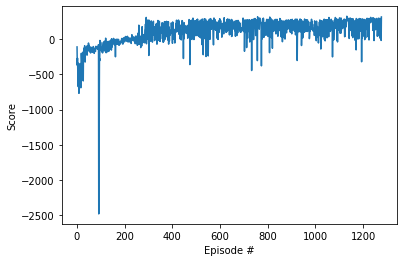

In [8]:
def ddpg(n_episodes=100000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        t = 0
        
        while(True):
            t += 1
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(t, state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        agent.actor_local.model.save('checkpoint_actor.h5')
        agent.critic_local.model.save('checkpoint_critic.h5')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            agent.actor_local.model.save('checkpoint_actor.h5')
            agent.critic_local.model.save('checkpoint_critic.h5')
            break
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 3: See the trained agent in action

In [13]:
from tensorflow.keras.models import load_model

trained_model = load_model('checkpoint_actor.h5', compile=False)

In [14]:
for i_episode in range(5):
    next_state = env.reset()
    
    score = 0.0
    
    t = 0
    while(True):
        t += 1
        env.render()
        
        next_state = np.expand_dims(next_state, axis=0)
        
        action = trained_model(next_state).numpy()[0]
        
        next_state, reward, done, info = env.step(action)
        
        score += reward
        if done:
            break
    
    print("Episode {0} finished after {1} timesteps. Total score: {2}".format(i_episode+1, t+1, score))
            
env.close()

Episode 1 finished after 208 timesteps. Total score: 274.75085333886335
Episode 2 finished after 273 timesteps. Total score: 287.5077449327542
Episode 3 finished after 171 timesteps. Total score: 271.9323350148343
Episode 4 finished after 203 timesteps. Total score: 254.2832547024381
Episode 5 finished after 224 timesteps. Total score: 285.2593698843828
